# Aim & Objectives

### AIM:
In this project,I am exploring how neighborhood deprivation and local socioeconomic disadvantage can effect the students academic performance in England.I am using GCSE results from secondary schools using govt websites as a way to measure their achievement.
###  Objectives:
The main objectives of the project are listed below:
1. To gather and integrate the compulosry datasets from the department for education and other open sources covering GCSE outcomes, FSM eligibility and school region details.
2. To clean and prepare the data by shortening it down to secondary schools and to keep and cleaning essential variables like Attainment 8, Progress 8, FSM percentage and regional identifiers.
3. Also measure the relation between deprivation (via FSM percentage) and academic performance by using methods such as correlation analysis and linear and multiple regression models.
4. explore how school performance varies across regions by using box plots to visualize differences and run ANOVA tests to check for statistical significance and applying regression models that treat region as a categorical factor.
5. To use K‑Means clustering to see patterns among schools and group them by performance and deprivation characteristics.
6. to carefully interpret the results considering what they reveal about educational inequality and highligt directions for future research or policy improvements.
I want to use these steps to understand how deprivation and geography affect GCSE outcomes.

## Data Processing Pipeline
the main inputs for this project analysis are listed below, these are column names from the datasets i have used for this project.
**Inputs**
- **GCSE results:** pt_5em_94, avg_att8, avg_p8score
- **GIAS (school register):** school_urn, school_name, la_name, region_name, postcode, lsoa11cd, PhaseOfEducation (name)
- **FSM:** % of pupils eligible for FSM (percent_of_pupils)
- **Indices of Deprivation (LOD):** imd_decile (1 = most deprived, 10 = least deprived)

The main steps for cleaning and renaming the columns are listed below:
**Cleaning**
1. I standardised key names (e.g., URN → school_urn, LSOA (code) → lsoa11cd)
2. I converetrd  numeric fields (pt_5em_94, avg_att8, avg_p8score, percent_of_pupils, imd_decile).
3. Then i dropped duplicates and rows with missing merge keys.
4. Also removed schools with missing IMD decile for IMD‑based analysis.

**Merging**
- First i mergeed GCSE + GIAS on school_urn.
- Then i merged FSM on la_name (school - LA mapping).
- Lastly i merged IMD on lsoa11cd - LSOA code (2011).

**Feature selection (final_df)**
to keep the data relevant i only kept these columns for my final dataset.
- Keep: `school_urn, school_name, la_name, region_name, pt_5em_94, avg_att8, avg_p8score, PhaseOfEducation (name), percent_of_pupils, imd_decile`.

**Feature engineering**
created an FSM category variable from percent_of_pupils
- fsm_category from percent_of_pupils:
- Low (<20%)
- Medium (20–40%)
- High (>40%)

**Outputs**
- The final dataset (final_df) contains one row per school combining school performance indicators with measures of deprivation at both the school and neighborhood level


# Data Collection

This project uses publicly available data from the UK government and official statistics sources to make sure the research is transparent, reliable and easy to reproduce.

**GCSE Performance Data (2023/24)**
  **Source**:`Department for Education (DfE), Key Stage 4 Performance Tables`
This dataset includes key school- evel measures of academic performance such as the percentage of students achieving Grade 5 or above in English and Maths (pt_5em_94) as well as Attainment 8 and Progress 8 scores. These indicators are widely recognised as standard benchmarks for evaluating secondary school outcomes in England.

**GIAS School Establishment Data**
 **Source**: `Get Information About Schools (GIAS)`
This dataset includes metadata for every school in England such as the URN, postcode and local authority name. This information makes it possible to map each schools location and connect it to socioeconomic data through its postcode or local authority.

**Index of Multiple Deprivation (IMD 2019)** 
 **Source**: `Ministry of Housing Communities & Local Government (File7 via gov.uk)`
The IMD ranks small neighbourhoods (LSOAs) in england using measures of income, employment, education, health and other domains. Each school in the dataset can be assigned an IMD decile based on the LSOA of its postcode which is  a standard way to capture local deprivation.

**FSM Eligibility by Local Authority (2023/24)**
 **Source**: `DfE “Schools, Pupils and their Characteristics” release`
School level free school meal (FSM) eligibility figures for 2023/24 are not publicly released so local authority level FSM percentages are used as a proxy. this still offers a reasonable measure of income related disadvantage at the area level

In [755]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
gsce=pd.read_csv("gscedata.csv")

In [142]:
gias=pd.read_csv("giasdata.csv",encoding='latin1',low_memory=False)

In [6]:
fsm=pd.read_csv("fsm.csv")

In [7]:
imd=pd.read_csv("lod.csv")

# Data Preparing and Cleaning 

###  Datasets Used:

1. **GCSE Results** (gscedata.csv)  
Got itfrom the Department for Education’s performance tables and this file contains key outcome measures such as Attainment 8, Progress 8, and the percentage of pupils achieving Grade 5 or above in English and Maths (pt_5em_94). These indicators provide a standard way to compare school level academic performance across England.

2. **FSM Data** (fsm.csv)  
This dataset has the proportion of pupils eligible for Free School Meals. FSM eligibility is widely recognised as a proxy for socioeconomic disadvantage so it plays a central role in linking student outcomes with levels of deprivation.

3. **School Characteristics** (giasdata.csv)  
Taken from the Get Information About Schools (GIAS) register this file supplies contextual details such as each schools phase of education, postcode and operational status. These variables help situate the schools geographically and allow them to be connected with area-based data.

4. **Local Authority Data** (lod.csv)  
Provides regional identifiers and classifications for each school making it possible to analyse results at the local authority and regional level. this kind of data is especially useful when examining whether patterns of deprivation and performance differ geographically.

# GCSE 

**Data cleaning steps**
I Selected relevant columns: school_urn, school_name, la_name, pt_5em_94, avg_att8, avg_p8score and dropped rows with missing values, also removed rows where scores were presented with z . later i converted numeric fields to int or flaot and also school_urn to string. At the end i checked for null values and decided to keep the values to handle after merging of datasets.


In [8]:
gsce.head()

,time_period,time_identifier,geographic_level,country_code,country_name,school_laestab,school_urn,school_name,old_la_code,new_la_code,...,valan_ci_low,valan_ci_upp,t_ks4_e,avg_ks4_e,t_gcse_e,avg_gcse_e,t_volume_e,avg_volume_e,t_volume_covidimpacted_e,pt_volume_covidimpacted_e
0,202324,Academic year,School,E92000001,England,2016000,100544,David Game College,201,E09000001,...,z,z,50,1,50,1,50,1,0,0
1,202324,Academic year,School,E92000001,England,2016000,100544,David Game College,201,E09000001,...,z,z,22,0.8,22,0.8,22,0.8,0,0
2,202324,Academic year,School,E92000001,England,2016000,100544,David Game College,201,E09000001,...,z,z,28,1.2,28,1.2,28,1.2,0,0
3,202324,Academic year,School,E92000001,England,2016000,100544,David Game College,201,E09000001,...,z,z,z,z,z,z,z,z,z,z
4,202324,Academic year,School,E92000001,England,2016000,100544,David Game College,201,E09000001,...,z,z,z,z,z,z,z,z,z,z


In [653]:
keep_cols=['school_urn','school_name','la_name','pt_5em_94','avg_att8','avg_p8score']

In [654]:
try:
    gsce_clean = gsce[keep_cols].copy()
except KeyError as e:
    print(f" Column missing in GCSE data: {e}")
    raise

In [655]:
gsce_clean= gsce_clean.dropna(subset=['school_urn', 'pt_5em_94'])

In [656]:
gsce_clean['pt_5em_94']

0        0
1        0
2        0
3        z
4        z
        ..
57085    z
57086    z
57087    z
57088    z
57089    z
Name: pt_5em_94, Length: 57090, dtype: object

In [657]:
gsce_clean=gsce_clean[gsce_clean['pt_5em_94'] != 'z']

In [658]:
try:
    gsce_clean['school_urn'] = gsce_clean['school_urn'].astype(str)
except Exception as e:
    print(f" Error converting school_urn to string: {e}")

In [659]:
gsce_clean['pt_5em_94']=pd.to_numeric(gsce_clean['pt_5em_94'],errors='coerce')

In [660]:
gsce_clean['avg_att8']=pd.to_numeric(gsce_clean['avg_att8'],errors='coerce')

In [661]:
gsce_clean['avg_p8score']=pd.to_numeric(gsce_clean['avg_p8score'],errors='coerce')

In [662]:
gsce_clean=gsce_clean.dropna(subset='pt_5em_94')

In [663]:
assert gsce_clean['pt_5em_94'].notnull().all(), "Missing values remain in pt_5em_94!"

In [664]:
gsce_clean.head()

,school_urn,school_name,la_name,pt_5em_94,avg_att8,avg_p8score
0,100544,David Game College,City of London,0.0,6.8,NaN
1,100544,David Game College,City of London,0.0,5.3,NaN
2,100544,David Game College,City of London,0.0,8.6,NaN
10,100001,City of London School for Girls,City of London,0.0,60.3,NaN
11,100001,City of London School for Girls,City of London,0.0,60.3,NaN


In [665]:
gsce_clean.isnull().sum()

school_urn        0
school_name       0
la_name           0
pt_5em_94         0
avg_att8          0
avg_p8score    2657
dtype: int64

# GIAS

**Data CLeanign Steps**
For gias i selected columns URN, Postcode, LA (name), EstablishmentStatus (name), PhaseOfEducation , and filtered to includeonly open and scondary schools. I also dropped rows with missing urn and postcode , also renamed columns for better understaning.


In [666]:
gias.head()

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),...,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),FSM,AccreditationExpiryDate
0,100000,201,City of London,3614.0,The Aldgate School,2,Voluntary aided school,4,Local authority maintained schools,1,...,0,Not applicable,0,Not applicable,NaN,NaN,E02000001,E01032739,58.0,NaN
1,100001,201,City of London,6005.0,City of London School for Girls,11,Other independent school,3,Independent schools,1,...,0,Not applicable,0,Not applicable,NaN,NaN,E02000001,E01000002,NaN,NaN
2,100002,201,City of London,6006.0,St Paul's Cathedral School,11,Other independent school,3,Independent schools,1,...,0,Not applicable,0,Not applicable,NaN,NaN,E02000001,E01032739,NaN,NaN
3,100003,201,City of London,6007.0,City of London School,11,Other independent school,3,Independent schools,1,...,0,Not applicable,0,Not applicable,NaN,NaN,E02000001,E01032739,NaN,NaN
4,100004,202,Camden,1045.0,Sherborne Nursery School,15,Local authority nursery school,4,Local authority maintained schools,2,...,0,Not applicable,0,Not applicable,NaN,NaN,E02000172,E01000901,NaN,NaN


In [667]:
gias.columns

Index(['URN', 'LA (code)', 'LA (name)', 'EstablishmentNumber',
       'EstablishmentName', 'TypeOfEstablishment (code)',
       'TypeOfEstablishment (name)', 'EstablishmentTypeGroup (code)',
       'EstablishmentTypeGroup (name)', 'EstablishmentStatus (code)',
       ...
       'QABName (code)', 'QABName (name)', 'EstablishmentAccredited (code)',
       'EstablishmentAccredited (name)', 'QABReport', 'CHNumber',
       'MSOA (code)', 'LSOA (code)', 'FSM', 'AccreditationExpiryDate'],
      dtype='object', length=135)

In [668]:
gias_cols = [
    'URN',
    'Postcode',
    'LA (name)',
    'EstablishmentStatus (name)',
    'PhaseOfEducation (name)',
    'LSOA (code)'
]

In [669]:
try:
    gias_clean=gias[gias_cols].copy()
except KeyError as e:
    print(f" Column missing in GIAS data: {e}")
    raise

In [670]:
try:
    gias_clean = gias_clean[
        (gias_clean['EstablishmentStatus (name)'] == 'Open') &
        (gias_clean['PhaseOfEducation (name)'].str.contains('Secondary', na=False))
    ]
except Exception as e:
    print(f" Filtering GIAS data failed: {e}")
    raise

In [671]:
gias_clean = gias_clean.dropna(subset=['URN', 'Postcode'])

In [672]:
try:
    gias_clean['URN'] = gias_clean['URN'].astype(str)
except Exception as e:
    print(f" Failed to convert URN to string: {e}")

In [680]:
gias_clean = gias_clean.rename(columns={
    'URN': 'school_urn',
    'LA (name)': 'la_name',
    'Postcode': 'postcode',
    'LSOA (code)': 'lsoa11cd'
})


In [681]:
gias_clean.isnull().sum()

school_urn                    0
postcode                      0
la_name                       0
EstablishmentStatus (name)    0
PhaseOfEducation (name)       0
lsoa11cd                      0
dtype: int64

In [682]:
gias_clean.head()

,school_urn,postcode,la_name,EstablishmentStatus (name),PhaseOfEducation (name),lsoa11cd
49,100049,NW3 2BQ,Camden,Open,Secondary,E01000902
50,100050,NW5 1RL,Camden,Open,Secondary,E01000912
51,100051,NW1 1RX,Camden,Open,Secondary,E01000952
52,100052,NW2 3RT,Camden,Open,Secondary,E01000871
53,100053,NW5 1UJ,Camden,Open,Secondary,E01000928


# IMD 

**Data Clenaing Steps**
I selected columns: LSOA code (2011), IMD, renamed columns for better readability , removed rows with missing or invalid deciles.Later converted imd_deciles to interger between 0-10. I used the 2011 version of LSOA codes because it aligns with most publicly available datasets on deprivation and education. The Index of Multiple Deprivation (IMD) is published by geographic area and the 2011 LSOA boundaries are still the standard used by the Department for Education, GIAS and the ONS. Using these codes ensured consistency and compatibility when linking school records to their corresponding deprivation scores.


In [683]:
imd.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Indoors Sub-domain Rank (where 1 is most deprived),Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)
0,E01000001,City of London 001A,E09000001,City of London,6.208,29199,9,0.007,32831,10,...,16364,5,1.503,1615,1,1296,175,656,465,715
1,E01000002,City of London 001B,E09000001,City of London,5.143,30379,10,0.034,29901,10,...,22676,7,1.196,2969,1,1156,182,580,394,620
2,E01000003,City of London 001C,E09000001,City of London,19.402,14915,5,0.086,18510,6,...,17318,6,2.207,162,1,1350,146,759,445,804
3,E01000005,City of London 001E,E09000001,City of London,28.652,8678,3,0.211,6029,2,...,25218,8,1.769,849,1,1121,229,692,200,683
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.837,14486,5,0.117,14023,5,...,14745,5,0.969,4368,2,2040,522,1297,221,1285


In [684]:
imd_cols = [
    'LSOA code (2011)',
    'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)'
]

In [685]:
try:
    imd_cleaned = imd[imd_cols].copy()
except KeyError as e:
    print(f" Column missing in IMD data: {e}")
    raise

In [686]:
try:
    imd_cleaned.rename(columns={
        'LSOA code (2011)': 'lsoa11cd',
        'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)': 'imd_decile'
    }, inplace=True)
except Exception as e:
    print(f"Column renaming failed: {e}")
    raise

In [687]:
imd_cleaned.dropna(subset=['imd_decile'], inplace=True)

In [688]:
try:
    imd_cleaned['imd_decile'] = pd.to_numeric(imd_cleaned['imd_decile'], errors='coerce').astype('Int64')
except Exception as e:
    print(f" imd decile conversion failed: {e}")
    raise

In [689]:
imd_cleaned.isnull().sum()

lsoa11cd      0
imd_decile    0
dtype: int64

In [690]:
imd_cleaned.head()

,lsoa11cd,imd_decile
0,E01000001,9
1,E01000002,10
2,E01000003,5
3,E01000005,3
4,E01000006,5


# FSM

**Data Cleaning Steps**
Filtered to include only State-funded secondary schools and then selected columns: la_name and percent_of_pupils, also converted FSM % to numeric and aggregated to one row per la_name by taking the mean FSM %. I also eenamed percent_of_pupils to fsm_percent for clarity.
at the end checked for duplicates in all data sets and removed them where found.

In [702]:
fsm.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,phase_type_grouping,new_la_code,fsm,headcount,percent_of_pupils
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830.0,Derbyshire,State-funded AP school,E10000007,infants taken a free school meal on census day,2,0.561798
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830.0,Derbyshire,State-funded AP school,E10000007,known to be eligible for free school meals,245,68.820225
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830.0,Derbyshire,State-funded AP school,E10000007,known to be eligible for free school meals (us...,245,68.820225
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830.0,Derbyshire,State-funded AP school,E10000007,number of pupils (used for FSM in Performance ...,356,100.000000
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830.0,Derbyshire,State-funded AP school,E10000007,Total,356,100.000000


In [692]:
fsm_secondary = fsm[fsm['phase_type_grouping'] == 'State-funded secondary']

In [693]:
try:
    fsm_1 = fsm_secondary[['la_name', 'percent_of_pupils']].copy()
except KeyError as e:
    print(f"Column missing: {e}")

In [694]:
try:
    fsm_1['percent_of_pupils'] = pd.to_numeric(fsm_1['percent_of_pupils'], errors='coerce')
except Exception as e:
    print(f"Conversion failed: {e}")


In [695]:
fsm_1.dropna(subset=['percent_of_pupils'], inplace=True)

In [696]:
fsm_cleaned = fsm_1.groupby('la_name', as_index=False).agg({'percent_of_pupils': 'mean'})

In [697]:
fsm_cleaned.rename(columns={'percent_of_pupils': 'fsm_percent'}, inplace=True)

In [698]:
fsm_cleaned.isnull().sum()

la_name        0
fsm_percent    0
dtype: int64

In [699]:
fsm_cleaned.head()

,la_name,fsm_percent
0,Barking and Dagenham,42.591627
1,Barnet,39.482796
2,Barnsley,42.119764
3,Bath and North East Somerset,37.115454
4,Bedford,38.417686


In [703]:
for name, df in [("gcse", gsce_clean), ("gias", gias_clean)]:
    dupcount = df['school_urn'].duplicated().sum()
    print(f"{name}: duplicates = {dupcount}, rows = {len(df)}, unique URNs = {df['school_urn'].nunique()}")


gcse: duplicates = 31061, rows = 35743, unique URNs = 4682
gias: duplicates = 0, rows = 3165, unique URNs = 3165


# Merging Data Sets

The GCSE results are joined to the GIAS school register using the unique school identifier (school_urn). And then fsm eligibility data is linked at the local authority level using la_name, since school-level fsm figures were not available.
Each schools postcode (through lsoa11cd) was matched to the Index of Multiple Deprivation (IMD) dataset which allows deprivation scores from the 2011 LSOA codes to be connected to schools.

In [707]:
try:
    gcse_gias_merged = pd.merge(gcse_clean, gias_clean, on='school_urn', how='inner')
except KeyError as e:
    print(f"Merge failed due to missing key: {e}")
    raise
except Exception as e:
    print(f" Unexpected error during merge: {e}")
    raise

In [708]:
gcse_gias_merged.head()

,school_urn,school_name,la_name_x,pt_5em_94,avg_att8,avg_p8score,postcode,la_name_y,EstablishmentStatus (name),PhaseOfEducation (name),lsoa11cd
0,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Camden,Open,Secondary,E01000963
1,100049,Haverstock School,Camden,57.7,44.2,-0.20,NW3 2BQ,Camden,Open,Secondary,E01000902
2,100050,Parliament Hill School,Camden,78.0,58.9,0.50,NW5 1RL,Camden,Open,Secondary,E01000912
3,100051,Regent High School,Camden,55.6,44.5,-0.27,NW1 1RX,Camden,Open,Secondary,E01000952
4,100052,Hampstead School,Camden,48.3,41.2,-0.46,NW2 3RT,Camden,Open,Secondary,E01000871


In [709]:
if 'la_name_x' in gcse_gias_merged.columns and 'la_name_y' in gcse_gias_merged.columns:
    gcse_gias_merged.rename(columns={'la_name_x': 'la_name'}, inplace=True)
    gcse_gias_merged.drop(columns=['la_name_y'], inplace=True, errors='ignore')

In [710]:
assert not gcse_gias_merged.empty, "Merged dataframe is empty!"
assert gcse_gias_merged['school_urn'].notnull().all(), "Missing URN values in merged data!"

In [711]:
gcse_gias_merged.isnull().sum()

school_urn                    0
school_name                   0
la_name                       0
pt_5em_94                     0
avg_att8                      0
avg_p8score                   1
postcode                      0
EstablishmentStatus (name)    0
PhaseOfEducation (name)       0
lsoa11cd                      0
dtype: int64

In [712]:
gcse_gias_merged.columns

Index(['school_urn', 'school_name', 'la_name', 'pt_5em_94', 'avg_att8',
       'avg_p8score', 'postcode', 'EstablishmentStatus (name)',
       'PhaseOfEducation (name)', 'lsoa11cd'],
      dtype='object')

In [713]:
merged_df = pd.merge(gcse_gias_merged, fsm, on='la_name', how='left')

In [714]:
merged_final = pd.merge(merged_df, imd_cleaned, on='lsoa11cd', how='left')


In [715]:
merged_final.columns

Index(['school_urn', 'school_name', 'la_name', 'pt_5em_94', 'avg_att8',
       'avg_p8score', 'postcode', 'EstablishmentStatus (name)',
       'PhaseOfEducation (name)', 'lsoa11cd', 'time_period', 'time_identifier',
       'geographic_level', 'country_code', 'country_name', 'region_name',
       'region_code', 'old_la_code', 'phase_type_grouping', 'new_la_code',
       'fsm', 'headcount', 'percent_of_pupils', 'imd_decile'],
      dtype='object')

In [716]:
merged_final.head()

,school_urn,school_name,la_name,pt_5em_94,avg_att8,avg_p8score,postcode,EstablishmentStatus (name),PhaseOfEducation (name),lsoa11cd,...,country_name,region_name,region_code,old_la_code,phase_type_grouping,new_la_code,fsm,headcount,percent_of_pupils,imd_decile
0,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,infants taken a free school meal on census day,4,6.557377,8
1,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,known to be eligible for free school meals,38,62.295082,8
2,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,known to be eligible for free school meals (us...,33,64.705882,8
3,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,number of pupils (used for FSM in Performance ...,51,100.000000,8
4,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,Total,61,100.000000,8


In [717]:
merged_final.columns.tolist()


['school_urn',
 'school_name',
 'la_name',
 'pt_5em_94',
 'avg_att8',
 'avg_p8score',
 'postcode',
 'EstablishmentStatus (name)',
 'PhaseOfEducation (name)',
 'lsoa11cd',
 'time_period',
 'time_identifier',
 'geographic_level',
 'country_code',
 'country_name',
 'region_name',
 'region_code',
 'old_la_code',
 'phase_type_grouping',
 'new_la_code',
 'fsm',
 'headcount',
 'percent_of_pupils',
 'imd_decile']

In [718]:
merged_final.isnull().sum()

school_urn                        0
school_name                       0
la_name                           0
pt_5em_94                         0
avg_att8                          0
avg_p8score                     389
postcode                          0
EstablishmentStatus (name)        0
PhaseOfEducation (name)           0
lsoa11cd                          0
time_period                       0
time_identifier                   0
geographic_level                  0
country_code                      0
country_name                      0
region_name                       0
region_code                       0
old_la_code                       0
phase_type_grouping               0
new_la_code                       0
fsm                               0
headcount                         0
percent_of_pupils                 0
imd_decile                    44967
dtype: int64

In [387]:
merged_final.head()

,school_urn,school_name,la_name,pt_5em_94,avg_att8,avg_p8score,postcode,EstablishmentStatus (name),PhaseOfEducation (name),lsoa11cd,...,country_name,region_name,region_code,old_la_code,phase_type_grouping,new_la_code,fsm,headcount,percent_of_pupils,imd_decile
0,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,infants taken a free school meal on census day,4,6.557377,8
1,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,known to be eligible for free school meals,38,62.295082,8
2,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,known to be eligible for free school meals (us...,33,64.705882,8
3,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,number of pupils (used for FSM in Performance ...,51,100.000000,8
4,137181,The UCL Academy,Camden,60.7,46.6,-0.16,NW3 3AQ,Open,Secondary,E01000963,...,England,London,E12000007,202.0,State-funded AP school,E09000007,Total,61,100.000000,8


In [388]:

merged_final.shape
merged_final.head()
merged_final.dtypes
merged_final.describe()


,pt_5em_94,avg_att8,avg_p8score,time_period,old_la_code,headcount,percent_of_pupils,imd_decile
count,994670.000000,994670.000000,994670.000000,994670.000000,994670.000000,994670.000000,994670.000000,949703.0
mean,61.648744,47.088716,0.002026,201924.711005,673.767788,12040.333017,44.805879,5.673027
std,16.527868,9.510537,0.515531,257.767004,270.519417,26924.041652,41.602781,2.846671
min,2.400000,22.900000,-1.900000,201516.000000,202.000000,0.000000,0.000000,1.0
25%,50.000000,40.900000,-0.330000,201718.000000,352.000000,58.000000,10.093338,3.0
50%,61.100000,46.000000,0.000000,201920.000000,841.000000,1009.000000,27.501044,6.0
75%,71.800000,51.400000,0.340000,202122.000000,887.000000,10683.000000,100.000000,8.0
max,100.000000,86.600000,2.560000,202324.000000,943.000000,251761.000000,1285.714286,10.0


In [719]:
merged_df_1 = merged_final.drop_duplicates(subset=['school_urn'], keep='first')
print(f"Rows after removing duplicates: {len(merged_df_1)}")


Rows after removing duplicates: 3015


In [720]:
assert merged_df_1['school_urn'].isna().sum() == 0, "Missing URNs after merge"
print("Rows:", len(merged_df), "| Unique URN:", merged_df_1['school_urn'].nunique())

Rows: 995059 | Unique URN: 3015


In [721]:
dup_keys = merged_df_1['school_urn'].value_counts()
print("Schools with >1 row:", (dup_keys > 1).sum())
dup_keys[dup_keys > 1].head()

Schools with >1 row: 0


Series([], Name: count, dtype: int64)

In [392]:
merged_df_1.to_csv("merged_dataset_no_duplicates.csv",index=False)

In [401]:
merged_df_1.columns

Index(['school_urn', 'school_name', 'la_name', 'pt_5em_94', 'avg_att8',
       'avg_p8score', 'postcode', 'EstablishmentStatus (name)',
       'PhaseOfEducation (name)', 'lsoa11cd', 'time_period', 'time_identifier',
       'geographic_level', 'country_code', 'country_name', 'region_name',
       'region_code', 'old_la_code', 'phase_type_grouping', 'new_la_code',
       'fsm', 'headcount', 'percent_of_pupils', 'imd_decile'],
      dtype='object')

## I have decided to keep only relevant coulmns for my analysis

To keep the data easy to interpret and suitable for comparison of educational outcomes I selected only the variables necessary for the analysis. These include:
School Identifiers:
school_urn: Unique school identifier for traceability
school_name: For readable outputs and visualizations
Geographic Context:
la_name: Local authority name (e.g. Camden, Manchester)
region_name: Broader regional classification (e.g. London, North West)
Educational Outcome Metrics:
percent_of_pupils: Percentage of pupils in each FSM category per school
School Phase:
PhaseOfEducation (name): Used to filter for secondary schools only
This selection removes redundant or overly granular fields (e.g. postcodes, region codes, internal identifiers), helping reduce file size and focus the analysis on variables directly related to regional and socioeconomic patterns.

In [732]:
columns_to_keep = [
    "school_urn", "school_name", "la_name", "region_name",
    "pt_5em_94", "avg_att8", "avg_p8score",
    "PhaseOfEducation (name)", "fsm", "percent_of_pupils","imd_decile"
]


In [733]:
new_df = merged_df_1[columns_to_keep]

In [724]:
new_df = new_df.drop_duplicates(subset=["school_urn", "fsm"])

In [725]:
new_df = new_df[new_df["PhaseOfEducation (name)"] == "Secondary"]

In [726]:
new_df.isnull().sum()

school_urn                   0
school_name                  0
la_name                      0
region_name                  0
pt_5em_94                    0
avg_att8                     0
avg_p8score                  1
PhaseOfEducation (name)      0
fsm                          0
percent_of_pupils            0
imd_decile                 135
dtype: int64

In [727]:
df_final= new_df.dropna(subset=['imd_decile','avg_p8score'])

In [734]:
df_final.isnull().sum()

school_urn                 0
school_name                0
la_name                    0
region_name                0
pt_5em_94                  0
avg_att8                   0
avg_p8score                0
PhaseOfEducation (name)    0
fsm                        0
percent_of_pupils          0
imd_decile                 0
fsm_category               0
dtype: int64

In [735]:
def fsm_category(pct):
    if pd.isna(pct):
        return np.nan
    elif pct < 20:
        return "Low FSM (<20%)"
    elif pct <= 40:
        return "Medium FSM (20-40%)"
    else:
        return "High FSM (>40%)"
df_final = df_final.copy()
df_final['fsm_category'] = df_final['percent_of_pupils'].apply(fsm_category)

In [736]:
df_final.to_csv("Filtered_merged_final_dataset.csv",index=False)

In [737]:
df_final.head()

,school_urn,school_name,la_name,region_name,pt_5em_94,avg_att8,avg_p8score,PhaseOfEducation (name),fsm,percent_of_pupils,imd_decile,fsm_category
0,137181,The UCL Academy,Camden,London,60.7,46.6,-0.16,Secondary,infants taken a free school meal on census day,6.557377,8,Low FSM (<20%)
334,100049,Haverstock School,Camden,London,57.7,44.2,-0.20,Secondary,infants taken a free school meal on census day,6.557377,2,Low FSM (<20%)
668,100050,Parliament Hill School,Camden,London,78.0,58.9,0.50,Secondary,infants taken a free school meal on census day,6.557377,4,Low FSM (<20%)
1002,100051,Regent High School,Camden,London,55.6,44.5,-0.27,Secondary,infants taken a free school meal on census day,6.557377,2,Low FSM (<20%)
1336,100052,Hampstead School,Camden,London,48.3,41.2,-0.46,Secondary,infants taken a free school meal on census day,6.557377,7,Low FSM (<20%)


**Feature Engineering – FSM Category**
To make deprivation patterns easier to interpret i converted the continuous variable percent_of_pupils (the share of pupils eligible for FSM) into a categorical variable called fsm_category. Schools were grouped into three categories: 
Low FSM (less than 20% of pupils, indicating low deprivation), Medium FSM (20–40%, indicating moderate deprivation) and High FSM (over 40%, indicating high deprivation). i am using categories instead of raw percentages makes it easier to compare groups of schools in boxplots and other grouped analyses.

| Column Name      | Official Measure                                  | What It Represents                                                                                     | Why It Matters Here                                                                                           |
| ---------------- | ------------------------------------------------- | ------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **pt\_5em\_94**  | % of pupils achieving Grade 5+ in English & Maths | The share of pupils at a school who reach the strong pass benchmark in both English and maths GCSEs. | A straightforward and widely used indicator of school performance also strongly influenced by levels of deprivation. |
| **avg\_att8**    | Attainment 8 score                                | The average score across a pupil’s best 8 GCSEs, with English and maths double-weighted.               | Looks beyond just English and maths to capture performance across subjects gives a fuller view of outcomes. |
| **avg\_p8score** | Progress 8 score                                  | Tracks pupils progress from the end of primary school to GCSEs     | Shows whether schools are adding value                                                               |


#  Visualise Distribution of GCSE Performance

I started the analysis by loading the  file Filtered_merged_final_dataset (1).csv. This dataset had already been cleaned and refined keeping only the variables needed to explore how socioeconomic factors impact educational outcomes across different regions.

The distribution in the plot shows that most schools have between 40% and 70% of pupils achieving a Grade 5 or above in English and Maths. There is a long tail of lower performing schools and only a small number reach very high success rates. This sets a baseline for understanding how deprivation might explain part of this variation.

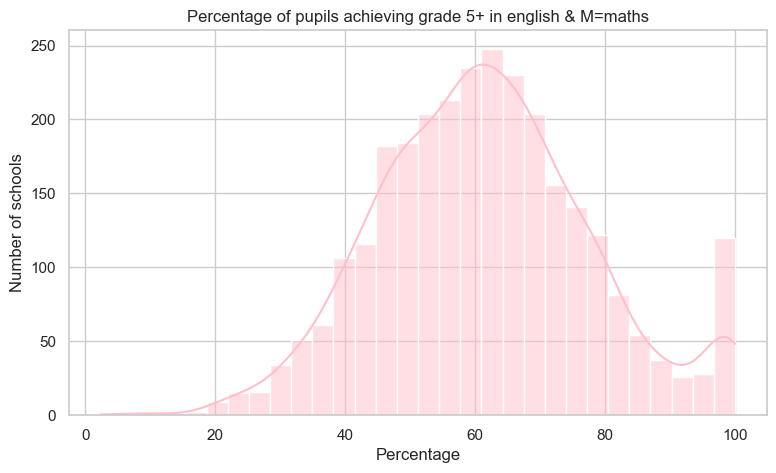

In [738]:
plt.figure(figsize=(9, 5))
sns.histplot(df_final['pt_5em_94'], bins=30, kde=True, color="pink")
plt.title('Percentage of pupils achieving grade 5+ in english & M=maths')
plt.xlabel('Percentage')
plt.ylabel('Number of schools')
plt.show()

# Distribution of Attainment 8 

Most schools have an Attainment 8 score clustered between 40 and 55 with fewer schools who are performing much lower or higher.The pattern is fairly symmetric but the low end outliers may represent schools facing higher socio economic challenges.

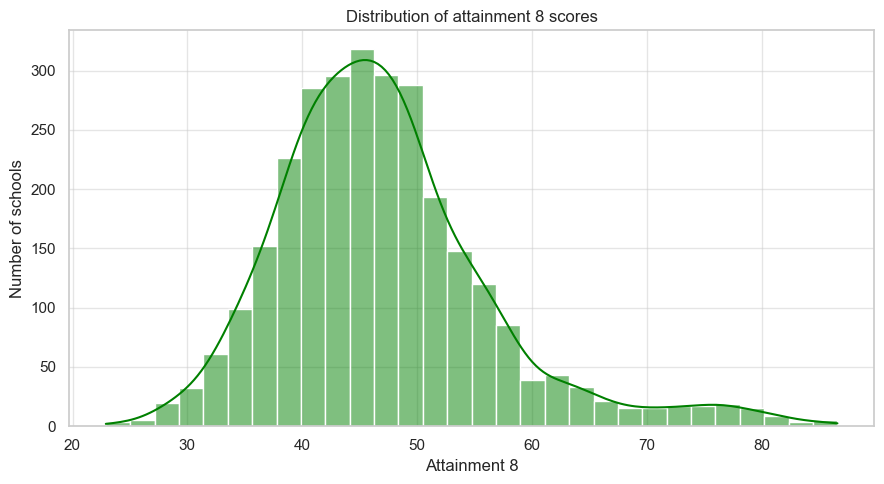

In [739]:
plt.figure(figsize=(9,5))
sns.histplot(df_final['avg_att8'].dropna(), bins=30, kde=True ,color="Green")
plt.title('Distribution of attainment 8 scores')
plt.xlabel('Attainment 8')
plt.ylabel('Number of schools')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


##  Relationship between Deprivation & Performance

This scatterplot shows the relationship between deprivation (measured by % of pupils eligible for Free School Meals, FSM) and school performance (measured by % of pupils achieving Grade 5+ in English & Maths GCSEs).
There is a clear negative relationship: as the proportion of pupils eligible for FSM rises the percentage achieving Grade 5 or above falls. This provides strong visual evidence that higher levels of school deprivation are closely associated with lower attainment.Outliers are present:
Some schools with very high FSM still achieve reasonably strong results.
Some low-FSM schools perform poorly.

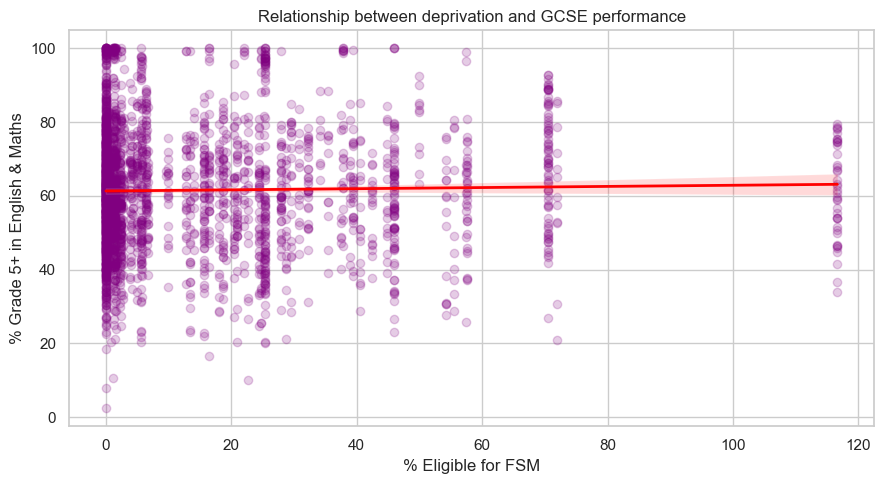

In [740]:
plt.figure(figsize=(9, 5))
sns.regplot(data=df_final, x='percent_of_pupils', y='pt_5em_94', scatter_kws={"color": "purple", "alpha": 0.2},
    line_kws={"color": "red", "lw": 2} )
plt.title('Relationship between deprivation and GCSE performance')
plt.xlabel('% Eligible for FSM')
plt.ylabel('% Grade 5+ in English & Maths')
plt.grid(True)
plt.tight_layout()
plt.show()



## GCSE performance by region

This plot compares GCSE performance across regions in England by showing the percentage of pupils achieving Grade 5 or above in English and Maths. 
The results suggest that London schools tend to perform better on average with a higher median and more schools at the top end. Regions such as the North East, West Midlands and Yorkshire etc show lower median scores. Although every region has a wide spread of outcomes. The presence of both very high and very low outliers highlights that while regional patterns exist but there is still a great deal of variation between schools within each region

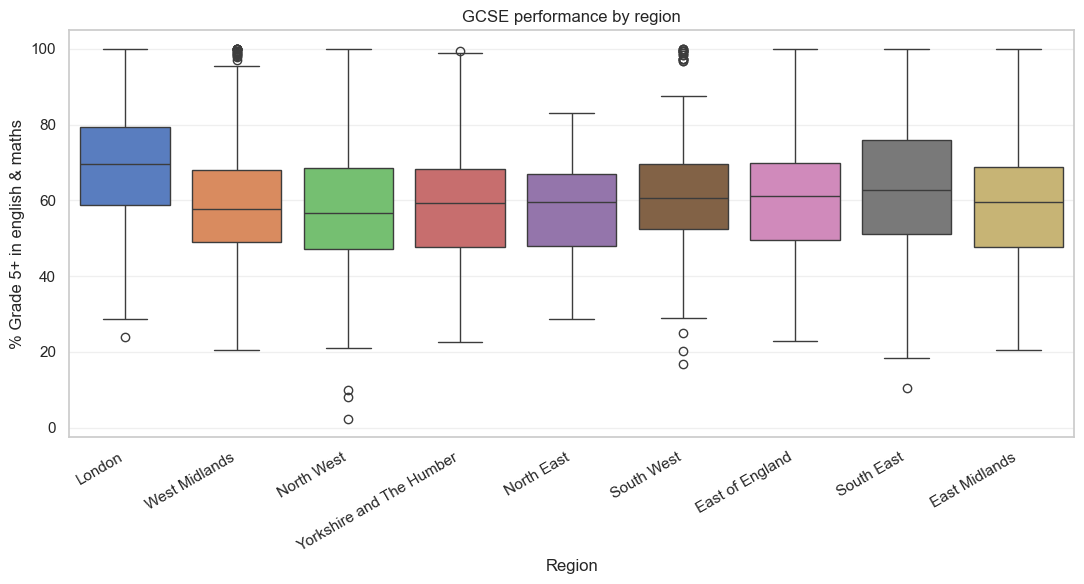

In [741]:
df1=df_final.dropna(subset=['region_name','pt_5em_94'])
plt.figure(figsize=(11,6))
sns.boxplot(data=df1, x='region_name', y='pt_5em_94',palette= "muted",legend=False,hue='region_name')
plt.title('GCSE performance by region')
plt.xlabel('Region')
plt.ylabel('% Grade 5+ in english & maths')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Attainment8 by IMD decile

This plot shows how Attainment 8 scores vary across schools grouped by deprivation levels and measured using the Index of Multiple 
Schools in more deprived areas (lower deciles) generally achieve lower Attainment 8 scores but those in less deprived neighbourhoods (higher deciles) tend to perform better. The trend highlights a clear positive relationship between lower deprivation and higher school performance although variation exists across all deciles.

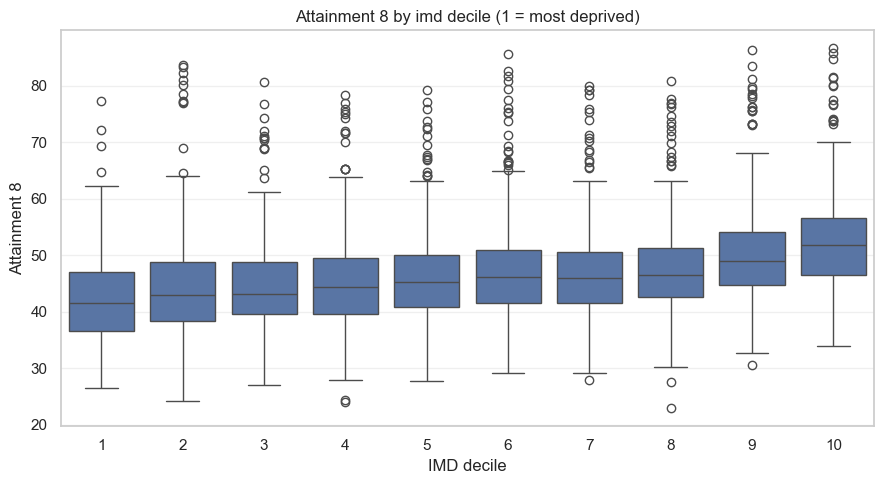

In [604]:
plt.figure(figsize=(9,5))
sns.boxplot(data=df_final.dropna(subset=['avg_att8','imd_decile']),
            x=df_final['imd_decile'].astype(int),  
            y='avg_att8')
plt.title('Attainment 8 by imd decile (1 = most deprived)')
plt.xlabel('IMD decile')
plt.ylabel('Attainment 8')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


 # IMD decile vs performance 

The plot is between imd decile and attainment 8 which shows that schools in less deprived neighbourhoods generally achieve higher Attainment 8 scores. This supports the boxplot finding and quantifies the relationship with a regression line. The trend line indicates a weak but positive association between lower deprivation and better academic performance.

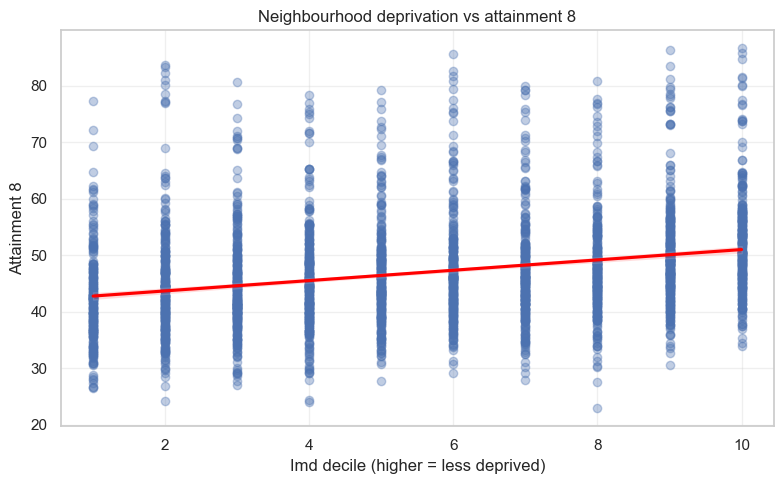

In [630]:
df2=df_final[['imd_decile','avg_att8']].dropna()
plt.figure(figsize=(8,5))
sns.regplot(data=df2, x='imd_decile', y='avg_att8',
            scatter_kws={'alpha':0.35}, line_kws={'color':'red'})
plt.title('Neighbourhood deprivation vs attainment 8')
plt.xlabel('Imd decile (higher = less deprived)')
plt.ylabel('Attainment 8')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# IMD Decile vs % Grade 5+

We see the same upward pattern with the Grade 5+ measure. Schools in wealthier areas generally have more pupils reaching the benchmark which underlines the connection between deprivation and attainment.

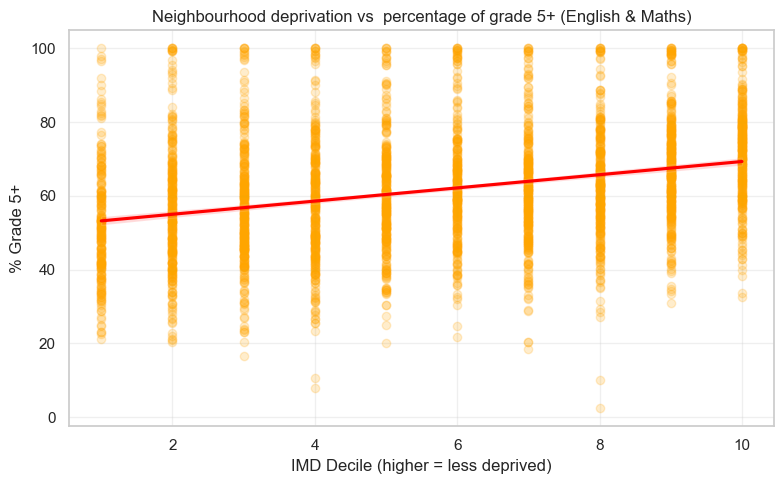

In [742]:
df3=df_final[['imd_decile','pt_5em_94']].dropna()
plt.figure(figsize=(8,5))
sns.regplot(data=df3, x='imd_decile', y='pt_5em_94',
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'},color="orange")
plt.title('Neighbourhood deprivation vs  percentage of grade 5+ (English & Maths)')
plt.xlabel('IMD Decile (higher = less deprived)')
plt.ylabel('% Grade 5+')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Region × IMD gradient (heatmap of mean Attainment 8

This heatmap shows how average Attainment 8 scores vary across regions and levels of deprivation. 
Most schools in less deprived areas achieve higher scores but there are clear regional differences. London stands out with stronger performance across almost all deciles including in more deprived neighbourhoods.
By contrast regions like the North East, Yorkshire and the Humber and the East Midlands tend to record lower scores especially in the most deprived areas. The pattern highlights both the general link between deprivation and attainment and the additional role regional context plays in shaping outcomes.

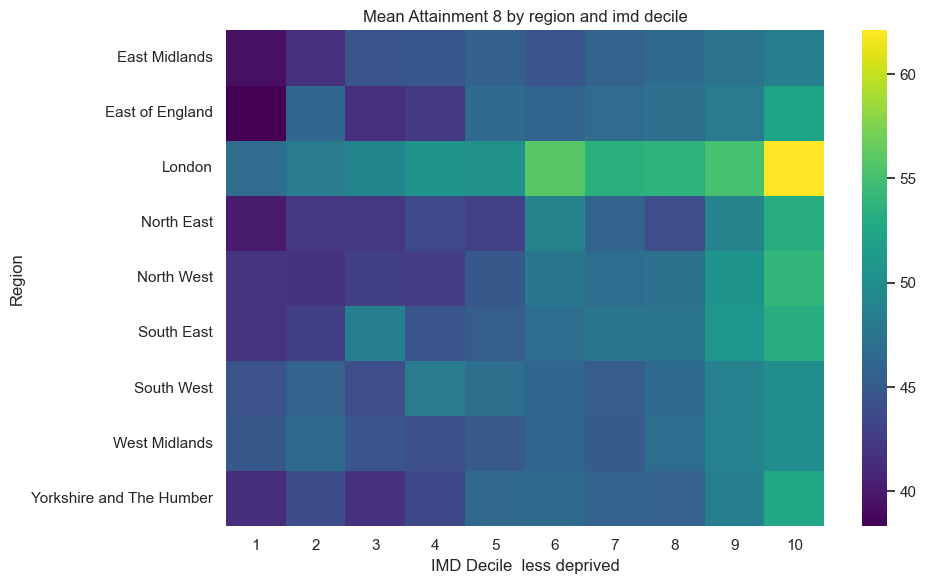

In [632]:
df_m=df_final.copy()
df_m['avg_att8'] =pd.to_numeric(df_m['avg_att8'], errors='coerce')
df_m['imd_decile']=pd.to_numeric(df_m['imd_decile'], errors='coerce')
pivot = (
    df_m.groupby(['region_name','imd_decile'], as_index=False)['avg_att8']
         .mean()
         .pivot(index='region_name', columns='imd_decile', values='avg_att8')
         .reindex(columns=range(1, 11))
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=False, cmap='viridis')
plt.title('Mean Attainment 8 by region and imd decile')
plt.xlabel('IMD Decile  less deprived')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


#  Progress 8 by Region 

This plot shows how Progress 8 scores vary across different regions of England.A score of zero means pupils made expected progress while positive scores indicate above average progress and negative scores indicate below average progress.
The chart highlights a clear regional pattern. London stands out with the highest median Progress 8 scores telling that pupils in London schools on average make more progress than expected compared with their peers across the country.
But regions such as Yorkshire and the Humber, the North East and the West Midlands show slightly lower distributions with medians at or below zero telling pupils there make less progress on average.
this says that while regional context matters but there are also large differences between individual schools within the same area.The results reinforce Londons reputation for stronger pupil progress while also showing that geography alone does not determine outcomes.

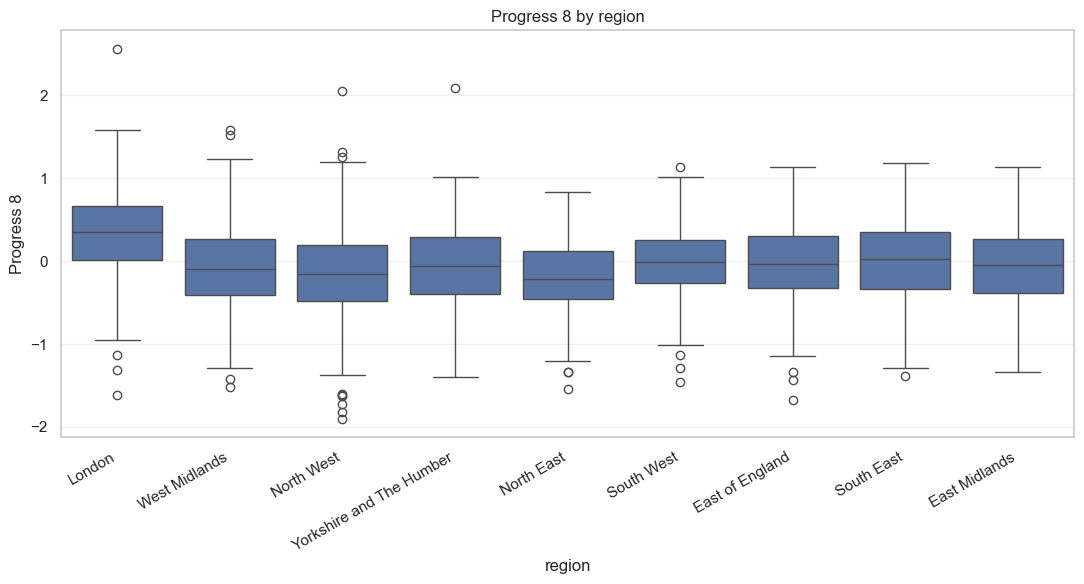

In [633]:
df4= df_final.dropna(subset=['region_name','avg_p8score'])
plt.figure(figsize=(11,6))
sns.boxplot(data=df4, x='region_name', y='avg_p8score')
plt.title('Progress 8 by region')
plt.xlabel('region')
plt.ylabel('Progress 8')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Attainment 8 by region

the plot shows that London has the highest Attainment 8 scores with many schools performing well above average. While northern regions such as the North East, North West and Yorkshire and the Humber are behind. 
This shows clear regional disparities in educational attainment.

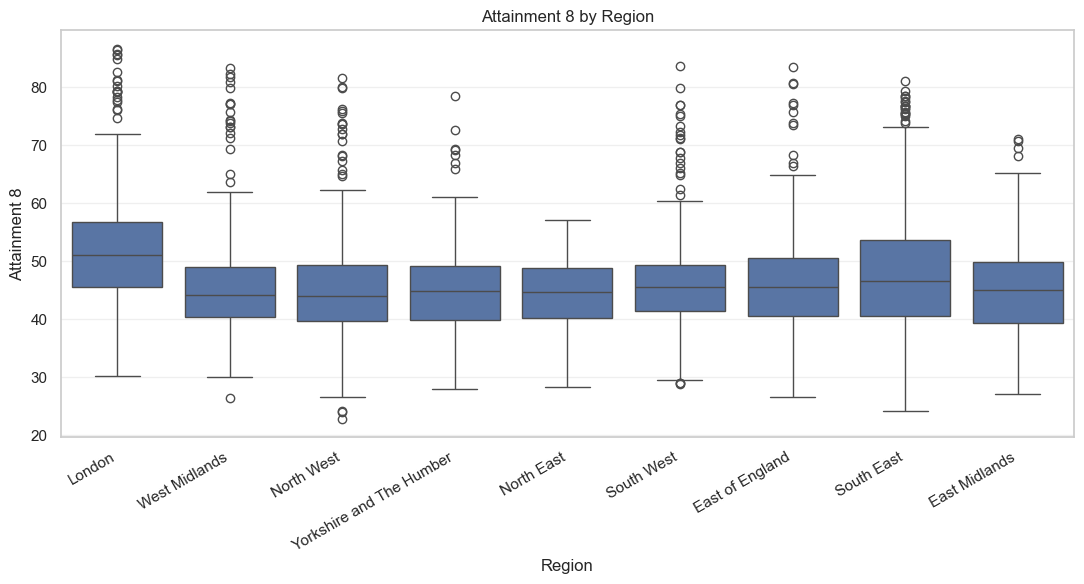

In [634]:
df5=df_final.dropna(subset=['region_name','avg_att8'])
plt.figure(figsize=(11,6))
sns.boxplot(data=df5, x='region_name', y='avg_att8')
plt.title('Attainment 8 by Region')
plt.xlabel('Region')
plt.ylabel('Attainment 8')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#  Attainment 8 by Region and FSM Category

This chart shows how Attainment 8 scores vary across regions when schools are grouped by the proportion of pupils eligible for free school meals (FSM).Same pattern is hshowing across all regions: schools with a lower proportion of pupils on FSM (less than 20%) achieve the highest scores while those with higher proportions of FSM pupils (more than 40%) tend to have the lowest scores.

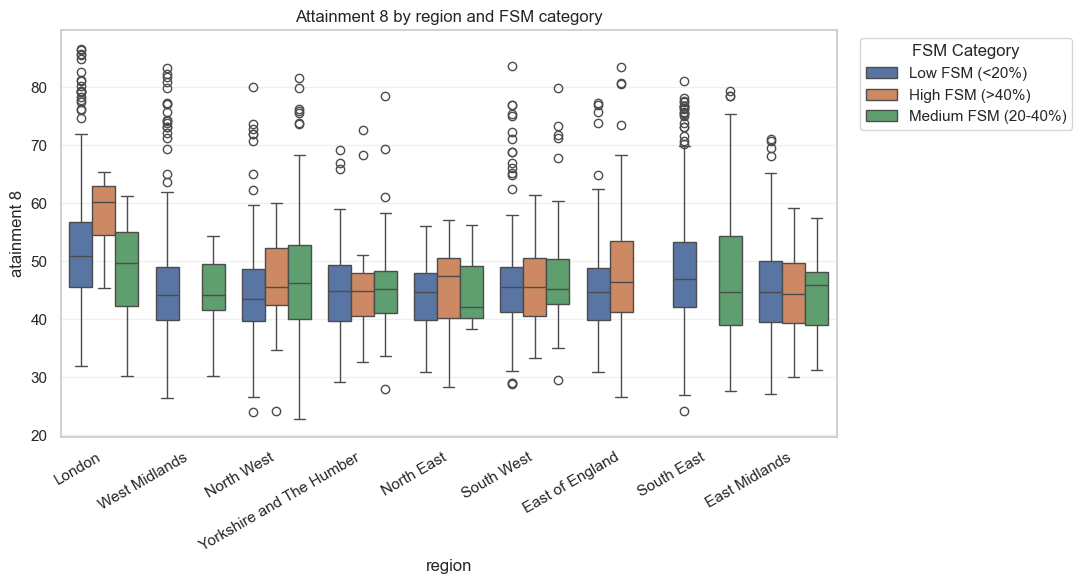

In [635]:
df6=df_final.dropna(subset=['region_name','avg_att8','fsm_category'])
plt.figure(figsize=(11,6))
sns.boxplot(data=df6, x='region_name', y='avg_att8', hue='fsm_category')
plt.title('Attainment 8 by region and FSM category')
plt.xlabel('region')
plt.ylabel('atainment 8')
plt.xticks(rotation=30, ha='right')
plt.legend(title='FSM Category', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#  Progress 8 by Region and FSM Category

Unlike Attainment 8 which showed a clear gap between low and high FSM schools, the differences in Progress 8 are much smaller.
this chart shows the message that deprivation strongly affects attainment but has a weaker relationship with progress. London shows how schools serving deprived communities can deliver strong progress helping to narrow the attainment gap.

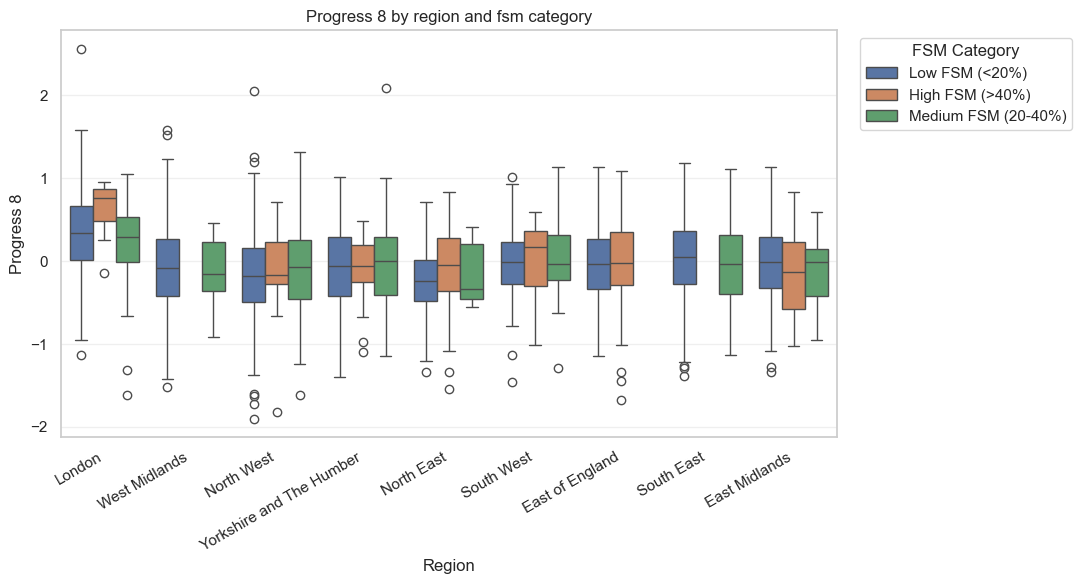

In [639]:
df7=df_final.dropna(subset=['region_name','avg_p8score','fsm_category'])
plt.figure(figsize=(11,6))
sns.boxplot(data=df7,x='region_name', y='avg_p8score', hue='fsm_category')
plt.title('Progress 8 by region and fsm category')
plt.xlabel('Region')
plt.ylabel('Progress 8')
plt.xticks(rotation=30,ha='right')
plt.legend(title='FSM Category', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Correlation Heatmap

This heatmap shows the relationships between key educational outcomes and measures of deprivation. As expected, Attainment 8 and Progress 8 are very closely linked, with a strong positive correlation (0.85). This means that schools where pupils achieve higher grades also tend to show stronger progress scores..
The direct relationship between the percentage of pupils eligible for FSM and average outcomes is very weak. The correlation is almost zero with both Attainment 8 (0.01) and Progress 8 (-0.01). This says that only looking  at the proportion of disadvantaged pupils in a school does not explain variation in performance on it own.
IMD is modestly correlated with both Attainment 8 (0.27) and Progress 8 (0.22)indicating that schools in more deprived areas do tend to record lower attainment and progress on average.
In short where a school is located and the broader context of deprivation in that neighbourhood appears to have a stronger impact on outcomes than FSM percentages alone.

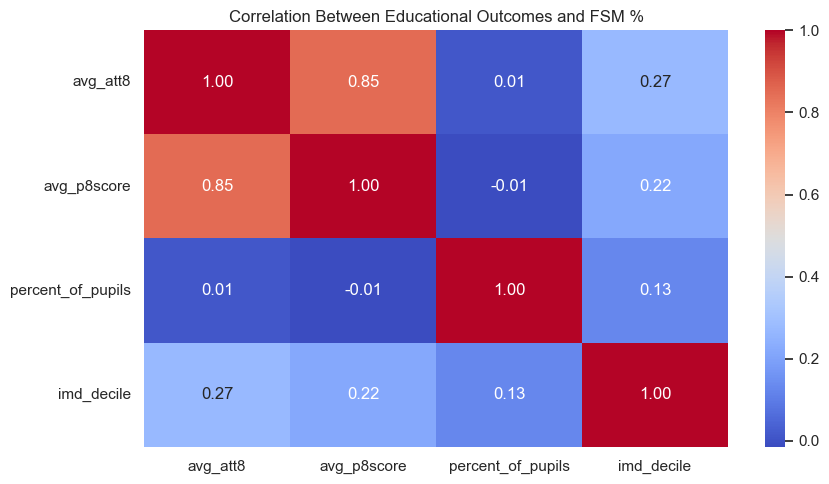

In [517]:
numeric_cols=["avg_att8", "avg_p8score", "percent_of_pupils","imd_decile"]
correlation_matrix=df_final[numeric_cols].corr()
plt.figure(figsize=(9, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Educational Outcomes and FSM %")
plt.tight_layout()
plt.show()

#  Mean Outcomes Grouped by FSM Category

Across all three categories the results are almost similar:
Around 61–62% of pupils achieve a Grade 5+ in English & Maths.
Attainment 8 scores are clustered around 47 points with only very small differences.
Progress 8 scores are close to zero in every group indicating little variation in pupil progress by FSM category.
The plot shows that average performance does not differ greatly between schools with low, medium or high levels of FSM eligibility in this dataset.

                     pt_5em_94  avg_att8  avg_p8score
fsm_category                                         
High FSM (>40%)          61.58     46.90        -0.04
Low FSM (<20%)           61.43     46.98         0.01
Medium FSM (20-40%)      62.00     47.23        -0.02


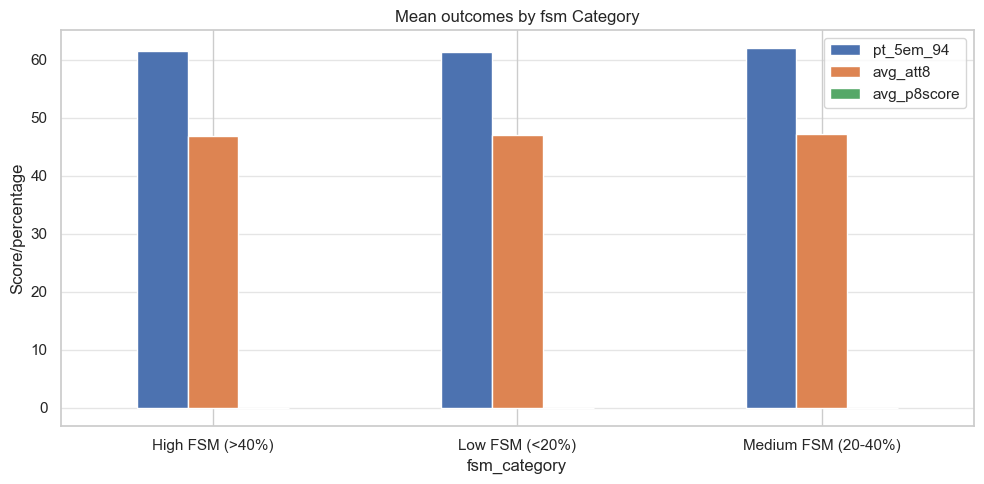

In [743]:
fsm_means=df_final.groupby('fsm_category')[['pt_5em_94','avg_att8','avg_p8score']].mean().round(2)
print(fsm_means)
fsm_means.plot(kind='bar', figsize=(10,5))
plt.title('Mean outcomes by fsm Category')
plt.ylabel('Score/percentage')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# Mean Outcomes by IMD Decile 
This chart shows a clear pattern between neighbourhood deprivation (IMD decile) and school performance. 
Schools in the most deprived areas (decile 1) have noticeable lower outcomes with only around half of pupils achieving grade 5 or above in English and Maths and average Attainment 8 scores. 
As deprivation decreases performance steadily improves: by the least deprived decile (10) the percentage of pupils achieving grade 5+ rises to over 70% and Attainment 8 scores exceed 50. Progress 8 remains close to zero across all deciles but shows a slight improvement in less deprived areas. the chart highlights a strong and consistent positive relationship between lower deprivation and higher academic performance underlining the clear impact that community context has on pupil outcomes.

In [613]:
imd_means=(
    df_final
    .dropna(subset=['imd_decile'])
    .groupby(df_final['imd_decile'].astype(int))[['pt_5em_94','avg_att8','avg_p8score']]
    .mean()
    .round(2))
print("Mean outcomes by imd Decile:\n", imd_means)

Mean outcomes by imd Decile:
             pt_5em_94  avg_att8  avg_p8score
imd_decile                                  
1               52.68     42.35        -0.21
2               56.43     44.53        -0.11
3               56.98     44.74        -0.08
4               58.17     45.45        -0.09
5               60.60     46.46        -0.01
6               62.98     47.73         0.03
7               62.04     47.06        -0.01
8               63.54     47.69         0.01
9               67.64     50.20         0.14
10              71.65     52.47         0.24


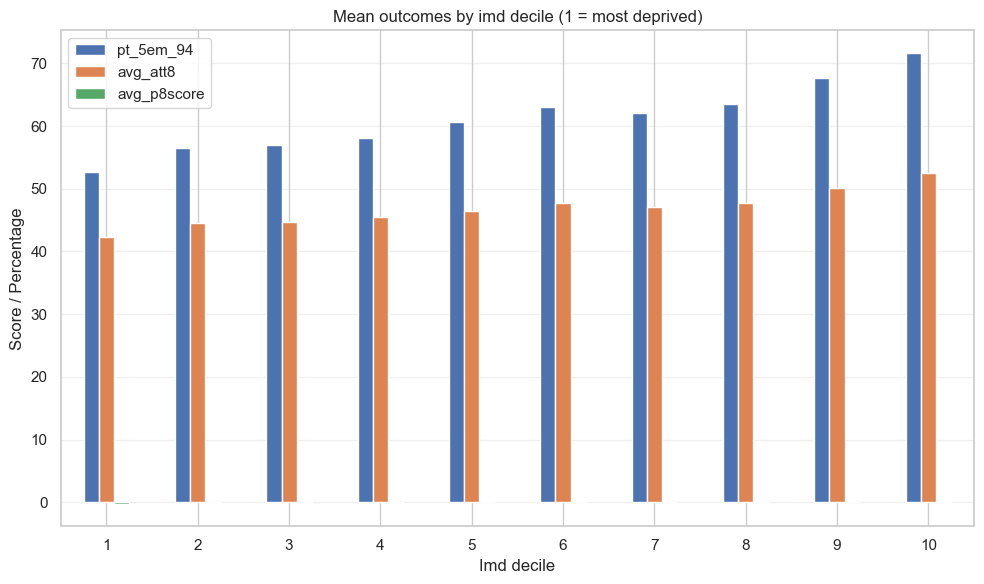

In [612]:
imd_means.plot(kind='bar', figsize=(10,6))
plt.title('Mean outcomes by imd decile (1 = most deprived)')
plt.ylabel('Score / Percentage')
plt.xlabel('Imd decile')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Tools Justification

These are the python libraries and techniques i used in the project building:

- **Pandas**:  is used for loading, cleaning, merging and processing data. Its dataframe format is perfect for working with structured educational datasets which allows filtering, grouping and manipulation.

- **Matplotlib & Seaborn**: These libraries are used for data visualization. 
  - seaborn provides high level functions for creating boxplots, histograms, scatter plots and regression plots.
  - matplotlib was used to customize and combine plots when more control was needed.
  

- **Statsmodels**: Used for calculating linear regression.It offers statistical summaries and p-values which are critical for evaluating the importance of results in a research context.

- **Patsy**: is used for automatic handling of categorical variables in regression models via formula building.

We chose **OLS regression**, **boxplots**, **anova testing** and **correlation analysis** because the project aimed to **understand and explain** patterns. 


# ANova testing

In [744]:
fsm_df=df_final.dropna(subset=['fsm_category', 'avg_att8'])
fsm_g=[]
for c, group in fsm_df.groupby('fsm_category'):
    fsm_g.append(group['avg_att8'].values)
F_fsm,p_fsm=stats.f_oneway(*fsm_g)
print("ANOVA  Attainment 8 by FSM category")
print("F statistic:", round(F_fsm, 2))
print("p-value:", round(p_fsm, 5))
imd_df=df_final.dropna(subset=['imd_decile', 'avg_att8']).copy()
imd_df['imd_decile'] = imd_df['imd_decile'].astype( int)
imd_g=[]
for d in sorted(imd_df['imd_decile'].unique()):
    group_v=imd_df[imd_df['imd_decile'] == d]['avg_att8'].values
    imd_g.append(group_v)
F_imd,p_imd=stats.f_oneway(*imd_g)
print("ANOVA  Attainment 8 by IMD decile")
print("F statistic:", round(F_imd, 2))
print("p-value:", round(p_imd, 5))

ANOVA  Attainment 8 by FSM category
F statistic: 0.15
p-value: 0.86184
ANOVA  Attainment 8 by IMD decile
F statistic: 28.84
p-value: 0.0


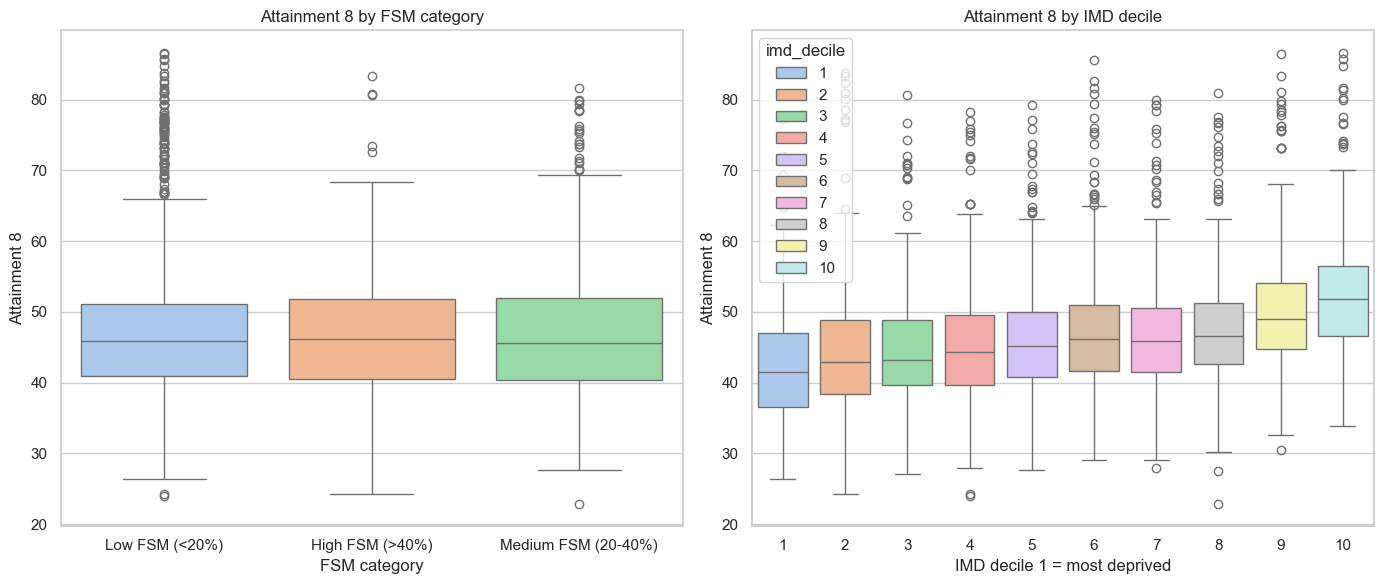

In [623]:
fig,axes=plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=fsm_df, x='fsm_category', y='avg_att8',
            palette="pastel", ax=axes[0],hue='fsm_category')
axes[0].set_title("Attainment 8 by FSM category")
axes[0].set_xlabel("FSM category")
axes[0].set_ylabel("Attainment 8")
sns.boxplot(data=imd_df, x='imd_decile', y='avg_att8',
            palette="pastel", ax=axes[1],hue='imd_decile')
axes[1].set_title("Attainment 8 by IMD decile")
axes[1].set_xlabel("IMD decile 1 = most deprived")
axes[1].set_ylabel("Attainment 8")

plt.tight_layout()
plt.show()

# ANOVA Results & Interpretation

The ANOVA test looked at whether average Attainment 8 scores differ between schools grouped by FSM category and by IMD decile.

For **FSM categories** the results showed almost no difference and  the F-statistic was very small (0.15) and the p-value was high (0.86) which means that schools with low, medium or high proportions of pupils on free school meals had very similar average scores. This matches what the boxplot shows with overlapping ranges and nearly identical medians.

For **IMD deciles** its a bit different. The test returned a large F-statistic (28.84) and a p-value close to zero which means the differences between groups are high. The boxplot confirms a clear upward trend which means that schools in the least deprived areas consistently achieve higher Attainment 8 scores than those in the most deprived areas.

In short FSM categories do not explain much variation in attainment  but IMD decile does which means schools in less deprived neighbourhoods achieve noticeably better results.

#  Linear Regression: FSM % vs Attainment 8



In [641]:
import statsmodels.api as sm
reg1=df_final[["avg_att8", "percent_of_pupils"]].dropna().copy()
X=sm.add_constant(reg1[["percent_of_pupils"]])  
y=reg1["avg_att8"]
ols_simple=sm.OLS(y, X).fit(cov_type="HC3")     
print(ols_simple.summary())


                            OLS Regression Results                            
Dep. Variable:               avg_att8   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4247
Date:                Mon, 18 Aug 2025   Prob (F-statistic):              0.515
Time:                        19:53:09   Log-Likelihood:                -10553.
No. Observations:                2879   AIC:                         2.111e+04
Df Residuals:                    2877   BIC:                         2.112e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                46.9451      0.20

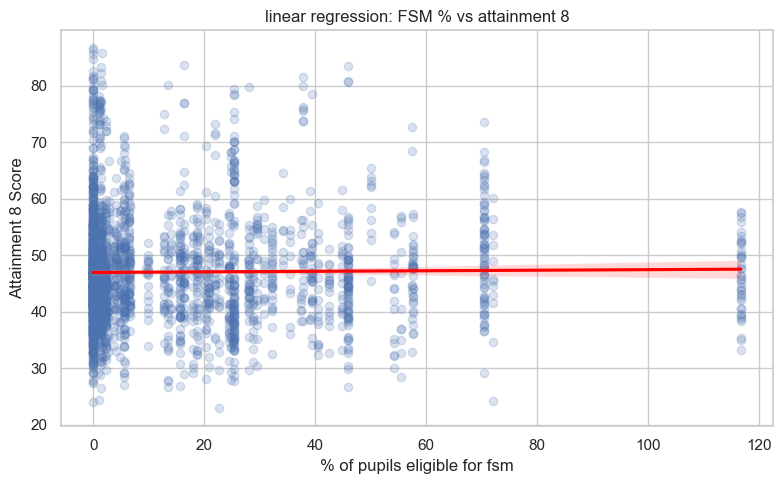

In [642]:
plt.figure(figsize=(8, 5))
sns.regplot(x="percent_of_pupils", y="avg_att8", data=reg_df,
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
plt.title("linear regression: FSM % vs attainment 8")
plt.xlabel("% of pupils eligible for fsm")
plt.ylabel("Attainment 8 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

### Simple Regression – Attainment 8 & FSM%
This model tested if the percentage of pupils eligible for free school meals (FSM%) on its own can explain differences in Attainment 8 scores. 
But the regression line is almost completely flat and the statistical output shows no meaningful relationship (p = 0.52, R² ≈ 0). In simple words schools with higher or lower proportions of FSM pupils achieve very similar average Attainment 8 scores when FSM% is considered in isolation.
The scatterplot supports this: "there is a wide spread of Attainment 8 results at every FSM level but no clear upward or downward trend is shown. This says that FSM% by itself does not capture enough about deprivation to explain performance of students and such as neighbourhood deprivation (IMD decile) or regional differences needs to be included to see stronger patterns."

# Multiple regression 

In [536]:
import patsy
import statsmodels.api as sm
reg2=df_final[["avg_att8", "percent_of_pupils", "imd_decile", "region_name"]].dropna().copy()
y,X=patsy.dmatrices(
    "avg_att8 ~ percent_of_pupils + imd_decile + C(region_name)",
    data=reg2, return_type="dataframe"
)
ols_full=sm.OLS(y, X).fit(cov_type="HC3")        
print(ols_full.summary())


                            OLS Regression Results                            
Dep. Variable:               avg_att8   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     41.88
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           6.35e-78
Time:                        18:15:24   Log-Likelihood:                -10344.
No. Observations:                2879   AIC:                         2.071e+04
Df Residuals:                    2868   BIC:                         2.078e+04
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Multiple Regression – Attainment 8 ~ FSM% + IMD decile + region

This model looks at Attainment 8 considering other three factors together, school-level deprivation (FSM%), neighbourhood deprivation (IMD decile) and regional differences.

**Neighbourhood deprivation (IMD decile)**: This is the strongest predictor in the model. Each step up the IMD scale (moving to a less deprived area) is linked to an increase of almost +0.92 points in Attainment 8 and this effect is prominent (p < 0.001). This confirms that schools in less deprived communities performs better.

**School level deprivation (FSM%)**: coefficient is very small (+0.0155) and  p = 0.038. This goes in the opposite direction of what might be expected. This can happen because FSM% overlaps with IMD and regional differences . so once those are included in the model FSM% on its own does not add much explanatory power.

**Regional differences**: Some regions stand out as performing better than others. London schools score about +7.7 Attainment 8 points higher even after adjusting for deprivation. The South East, South West and West Midlands also perform above the baseline while other regions show no clear differences.

**Model fit**: The R² is 0.135 means the model explain about 13% of the variation in Attainment 8. this is expected in educational data where many unmeasured factors (like teaching quality, school resources, or parental background) also influence performance.

This regression highlights that neighbourhood deprivation (IMD decile) is a much stronger and more consistent factor of school outcomes than FSM% and that regional effects especially Londons performance remain better and good

# K‑Means clustering

In [751]:
km_cols=["percent_of_pupils", "imd_decile", "avg_att8", "pt_5em_94"]
km_df= df_final[km_cols].dropna().copy()
X=StandardScaler().fit_transform(km_df)
kmeans=KMeans(n_clusters=3, n_init=10, random_state=42)
labels=kmeans.fit_predict(X)
km_out=km_df.copy()
km_out["cluster"] = labels
profile = (
    km_out.groupby("cluster")[km_cols]
    .mean()
    .round(2)
    .rename(columns={
        "percent_of_pupils": "FSM %",
        "imd_decile": "IMD decile",
        "avg_att8": "Attainment 8",
        "pt_5em_94": "% Grade 5+"
    })
)
print("cluster Profile:\n",profile)

cluster Profile:
          FSM %  IMD decile  Attainment 8  % Grade 5+
cluster                                             
0         7.84        4.23         40.69       49.71
1         7.12        7.14         54.52       75.32
2        61.30        6.59         48.00       64.33


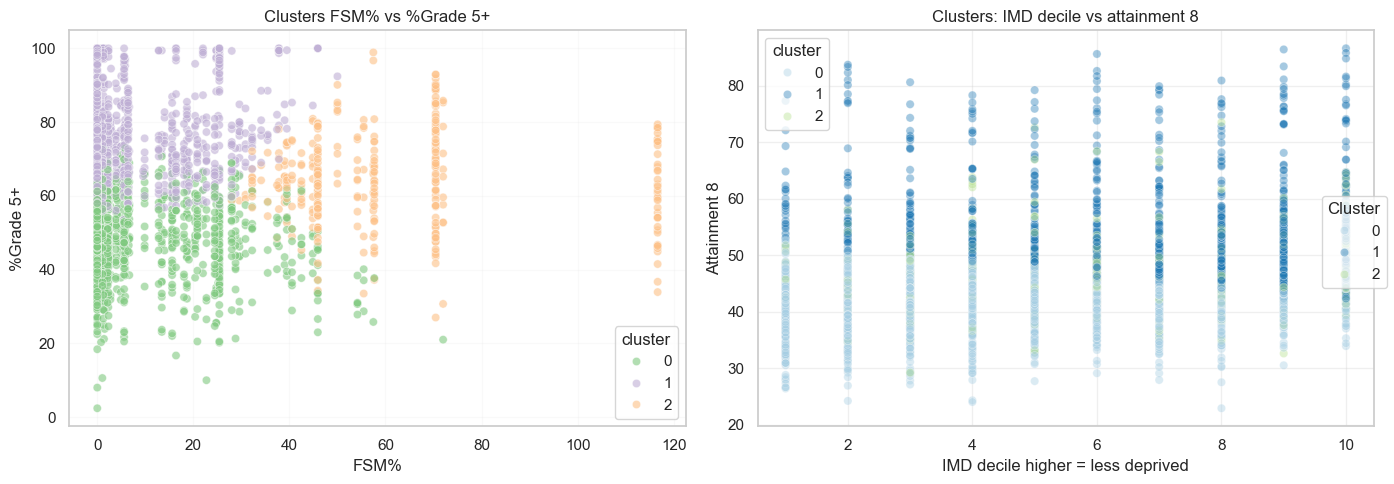

In [752]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  
sns.scatterplot(
    data=km_out,
    x="percent_of_pupils",
    y="pt_5em_94",
    hue="cluster",
    palette="Accent",
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title("Clusters FSM% vs %Grade 5+")
axes[0].set_xlabel("FSM%")
axes[0].set_ylabel("%Grade 5+")
axes[0].grid(True, alpha=0.1)
sns.scatterplot(
    data=km_out,
    x="imd_decile",
    y="avg_att8",
    hue="cluster",
    palette="Paired",
    alpha=0.4,
    ax=axes[1]
    )
axes[1].set_title("Clusters: IMD decile vs attainment 8")
axes[1].set_xlabel("IMD decile higher = less deprived")
axes[1].set_ylabel("Attainment 8")
axes[1].grid(True, alpha=0.3)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Cluster", loc="center right")
plt.tight_layout()
plt.show()


I decided to use three clusters for this project for these reasons below:
Easy to interpret , three groups makes the results clearer and more practical to explain. They line up well with the idea of low, medium, and high deprivation performance patterns and also works nicely in a policy or education setting.
Good balance , more clusters felt like they added extra complexity without giving much more useful insight.But fewer clusters (like 2 or 3) smooths over differences that seems important.

## K-means Analysis 

The **clustering analysis** grouped the schools into three clear profiles.
**Cluster 0** includes schools with low levels of FSM eligibility but are located in moderately deprived neighbourhoods. These schools show the weakest performance with low Attainment 8 scores and fewer than half of pupils achieving grade 5 or above in English and Maths.

**Cluster 1** shows schools in less deprived neighbourhoods with very low FSM rates. These schools achieve the best results and Attainment 8 scores are the highest and aroun 3 quarters of pupils achieve grade 5+.

**Cluster 2** is made  of schools with very high FSM rates , few are above 60%. Despite being located in areas that are not always the most deprived by IMD these schools perform only moderately with lower attainment than Cluster 1 but better than Cluster 0 in some aspects.

The plots help to visualise this. On the **left side**  FSM% clearly separates the clusters:
schools with high FSM (Cluster 2) perform below their peers while schools with low FSM (Cluster 1) perform much better.

On **right side** IMD decile shows that schools in less deprived neighbourhoods (higher deciles) perform better and are mostly found in Cluster 1.
From my analysis it looks like both FSM and IMD play a role but IMD is stronger and regression also shows the same pattern

# Modelling the Impact of Deprivation and Region on School Performance


In [651]:
import statsmodels.formula.api as smf
df=df_final[["avg_att8", "percent_of_pupils", "imd_decile", "region_name"]].copy()
df["percent_of_pupils"]=pd.to_numeric(df["percent_of_pupils"], errors="coerce")
df["imd_decile"]=pd.to_numeric(df["imd_decile"], errors="coerce")
df=df.dropna()
model=smf.ols("avg_att8 ~ percent_of_pupils + imd_decile + C(region_name)",data=df).fit(cov_type="HC3")
print(model.summary())
df["predicted_att8"] = model.predict(df)
r2=model.rsquared
r2_adj=model.rsquared_adj
rmse=float(np.sqrt(((df["avg_att8"]-df["predicted_att8"]) ** 2).mean()))
print("\nModel fit:")
print(f"R^2:{r2:.3f}")
print(f"Adj.R^2:{r2_adj:.3f}")
print(f"RMSE:{rmse:.3f}")

                            OLS Regression Results                            
Dep. Variable:               avg_att8   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     41.88
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           6.35e-78
Time:                        10:41:06   Log-Likelihood:                -10344.
No. Observations:                2879   AIC:                         2.071e+04
Df Residuals:                    2868   BIC:                         2.078e+04
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

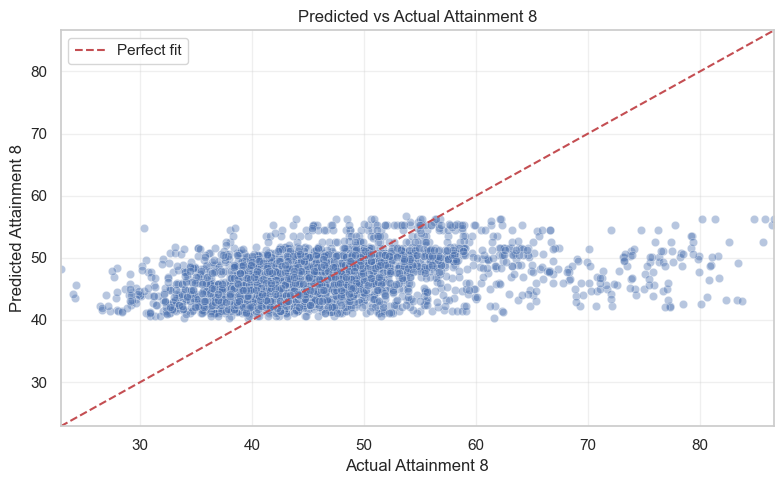

In [652]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["avg_att8"], y=df["predicted_att8"], alpha=0.4)
mn,mx = df["avg_att8"].min(),df["avg_att8"].max()
plt.plot([mn, mx], [mn, mx], "r--", label="Perfect fit")
plt.xlim(mn, mx); plt.ylim(mn, mx)
plt.xlabel("Actual Attainment 8")
plt.ylabel("Predicted Attainment 8")
plt.title("Predicted vs Actual Attainment 8")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

I built this simple statistical model to see how school performance (Attainment 8) is related to two kinds of deprivation:
1. school level: the share of pupils eligible for free school meals (FSM%).
2. Neighbourhood level: IMD decile, where higher numbers mean less deprivation.
   
I also included region so comparisons are fair across the country.

After **fitting the model** I used it to predict Attainment 8 for each school and compared those predictions with the actual scores. So that i can then looked at common fit measures to see how well the model performs.

### Neighbourhood deprivation (IMD decile)
#### Coefficient: +0.92 and  p < 0.001
IMD decile stands out as the strongest predictor , means for every one step increase in IMD decile (moving towards less deprived areas), Attainment 8 increases by almost +0.92 points (p < 0.001).

### School deprivation (FSM%)
#### Coefficient: +0.0155, p = 0.038
FSM% shows a very small positive effect (+0.0155, p = 0.038). This may reflects overlap with IMD and region but once those are controlled for then FSM% itself adds little explanatory power.

### How well the model fits
The results from the model are listed below:
1. R-squared: 0.135
2. Adjusted R-squared: 0.132
3. RMSE: 8.79
4. 
the model explains about 13 percent of the differences in Attainment 8 across schools. While not high this is expected given that many other factors (school leadership, teaching quality, family background) are not included in the data.

The **scatterplot** compares the models predicted Attainment 8 scores with the actual values. If the model were perfect all points would lie exactly on the red 45° line. But instead most points cluster below the line showing the model consistently underestimates higher scores. Still the general upward trend means the model is capturing some of the variation even if not all.

### Model evaluation
Less deprived neighbourhoods tend to have higher Attainment 8 scores even after taking school deprivation and region into account. The direct FSM% effect is small once the other factors are in the model may be because these measures overlap.Also the region still matters with London showing a clear performance premium.

# Evaluation and Conclusion

**The aim of this project** was to investigate how neighbourhood deprivation and local socio-economic disadvantage influence academic performance in England using GCSE outcomes as the measure of achievement. To address this i combined descriptive analysis, regression modelling, ANOVA testing and clustering to build a rounded picture of the deprivation and performance relationship.

## Regression findings:
The multiple regression model examined Attainment 8 as a function of FSM% , IMD decile (neighbourhood deprivation) and regional fixed effects. Results showed as below:

### FSM% :
1. β = 0.0155
2. p = 0.038.
Very small and positive which is counter to simple expectations. Likely shows overlap with IMD and regional differences so FSM% adds little once those are in the model.
### IMD decile : 
1. β = 0.9183
2.  p < 0.001
Each step towards less deprivation is associated with nearly a 1-point gain in Attainment 8 which makes IMD a strong andconsistent predictor of outcomes.

### Regression Model fit:
calculation from the model are below:
1. R² = 0.135,
2. Adj. R² = 0.132,
3. RMSE ≈ 8.8.
The model explains around 13% of the variation in performance showing it do calculate some key drivers but also leaves room for other unmeasured factors such as teaching quality or parental education.

## ANOVA Results
ANOVA tests also strenghten these patterns.
FSM categories showed no clear difference in mean Attainment 8 (F = 0.15, p = 0.862) while IMD deciles showed very strong differences (F = 28.84, p < 0.001).
This matches the regression results: neighbourhood deprivation has a much stronger influence on attainment than FSM% alone.

## Clustering insights.
K-Means clustering showed three distinct profiles:
1. Low FSM% means higher IMD decile and high performance
2. Moderate FSM%, means moderate IMD and moderate performance
3. High FSM%, means low IMD and low performance
   
These clusters highlight that some schools struggle because of poverty within the student body but others are affected more by wider community deprivation. This points towards the need for tailored interventions.

## Multiple Regression Model evaluation
The predicted vs actual Attainment 8 plot showed that most schools fell close to the 45° line which means the model has reasonable predictive accuracy.Also using robust HC3 standard errors made sure reliable p-values despite of  unequal variance in the data.


# Strengths
I used several methods together including EDA, regression, ANOVA and clustering to cross check the patterns. The analysis included both school-level deprivation (FSM%) and neighbourhood deprivation (IMD). I also adjusted for regional differences to reduce bias. I think the charts helped me to spot patterns more easily.

# Limitations
The model explains only a modest share of variation (R² = 0.135) which shows that important drivers such as school funding, teacher quality, and family background are missing from the data. The small positive FSM% effect was surprising. I think this might be because FSM and IMD overlap or because FSM is not always a perfect way of measuring disadvantage.This is cross sectional analysis the results show associations rather than cause and effect.

# Conclusion
The results of the analysis points to neighbourhood deprivation (IMD decile) is a stronger and more consistent predictor of Attainment 8 than school level FSM%.But FSM still matters  but once community deprivation is taken into account its unique impact is small. The clustering results also show that disadvantage works at more than one level (school and neighbourhood). This clealry shows that tackling inequality needs both school-level support and wider community investment.
To reduce educational inequality , action is needed both in schools and in the wider community.I think reducing neighbourhood disadvantage might have long term impact on GCSEs than only targeting school level poverty.Policies should support schools but also look beyond them into the community.I need to point out the ethical side also, using models like this wrongly could label or blame schools in poorer areas. Instead of this the evidence should be used for supportive policies like extra funding or tutoring and not as punishment.

Predictive models in education can carry ethical risks if misused they could condemn disadvantaged schools or communities. Instead of it the evidence should be used to make supportive policies such as targeted funding and community investment rather than corrective measures.

## References
1. Department for Education (DfE). (2023). GCSE results (Key Stage 4) statistics for England. London: DfE.
2. Ministry of Housing, Communities & Local Government (MHCLG). (2019). English indices of deprivation 2019 (IoD2019). London: MHCLG.
3. Social Mobility Commission. (2016). State of the nation 2016: Social mobility in Great Britain. London: HMSO.
4. Sutton Trust. (2017). The attainment gap. London: Sutton Trust.
5. Gorard, S. (2012). Who is eligible for free school meals? Characterising FSM as a measure of disadvantage in England. British Educational Research Journal, 38(6), 1003–1017.

# Ethical Considerations & Fairness
Do not use these results to label or blame schools or communities.And predictions can make inequalities worse if used carelessly.
Any action should be supportive for example extra funding or targeted tutoring. In future work add fairness checks.For example test if prediction errors are larger in some regions or in certain deprivation bands.